In [1]:
import os
os.environ["OPENAI_API_KEY"] = ''

from openai import OpenAI
client = OpenAI()

In [16]:
import pandas as pd
data = pd.read_csv('test_data_eval_5.csv')
data.shape

(500, 16)

In [32]:
system_prompt = """You are a historian super curious about the history of Venice in 1741.
You are asked a question a about properties owned by people in Venice 1741.
Usually the question refer to the following information: Names of the property owners; Type of the property; Rent price of the property; Ancient approximate toponym of the property."""

prompt = """Given the following question, rate this question in terms of its interestingness from 1 to 100. 
1 is the most boring question, that nobody cares about, and 100 is the most interesting question that everyone is curious about.

Return only the rate value between 1 and 100.

### Question:
{question}

### Interestingess Rate:
"""

In [33]:
questions = data.iloc[list(range(4,500,5))]['question'].tolist()

In [34]:
questions[0]

'List all the types of properties in the dataset.'

In [31]:
response = client.chat.completions.create(
  model="gpt-4-turbo-preview",
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": prompt.format(question=questions[0])}
  ]
)
response.choices[0].message.content

'25'

In [35]:
# Rate the questions in terms of interestingness
question_rates = []
for question in questions:
    response = client.chat.completions.create(
        model="gpt-4-turbo-preview",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt.format(question=question)}
        ]
    )
    question_rates.append(response.choices[0].message.content)

In [62]:
question_rates_expanded = [x for x in question_rates for _ in range(5)]

In [63]:
data['interest_rate'] = question_rates_expanded

In [75]:
data.to_csv('test_data_with_interest.csv',index=False)

# Analyze accuracy in terms of interestingness

In [1]:
import pandas as pd
data = pd.read_csv('test_data_with_interest.csv')

In [16]:
org_questions = pd.read_csv("/scratch/students/saydalie/venice_llm/text_to_sql/data/test_data_1_sql.csv")
data_merged = pd.merge(org_questions[['question']], data[['question','level_len','level_nest','interest_rate']], on=['question'], how='left')

In [17]:
data_merged.reset_index(drop=True).to_excel('question_full.xlsx')

In [2]:
# difficulty
data['output_binary_3'] = (data.output_3!='False')
data['output_binary_5'] = (data.output_5!='False')
data['output_binary_7'] = (data.output_7!='False')

In [7]:
data_by_interest_rate = data[['interest_rate','output_binary_3','output_binary_5','output_binary_7']].sort_values(by='interest_rate', ascending=True)

,interest_rate,output_binary_3,output_binary_5,output_binary_7
289,12,True,True,True
288,12,False,False,False
287,12,True,True,True
286,12,True,True,True
285,12,True,True,True
...,...,...,...,...
316,88,False,False,False
318,88,True,True,True
319,88,True,True,True
315,88,True,True,True


In [49]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
# bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
data_by_interest_rate['interest_rate_groups'] = pd.cut(data_by_interest_rate['interest_rate'], bins=bins, labels=labels)

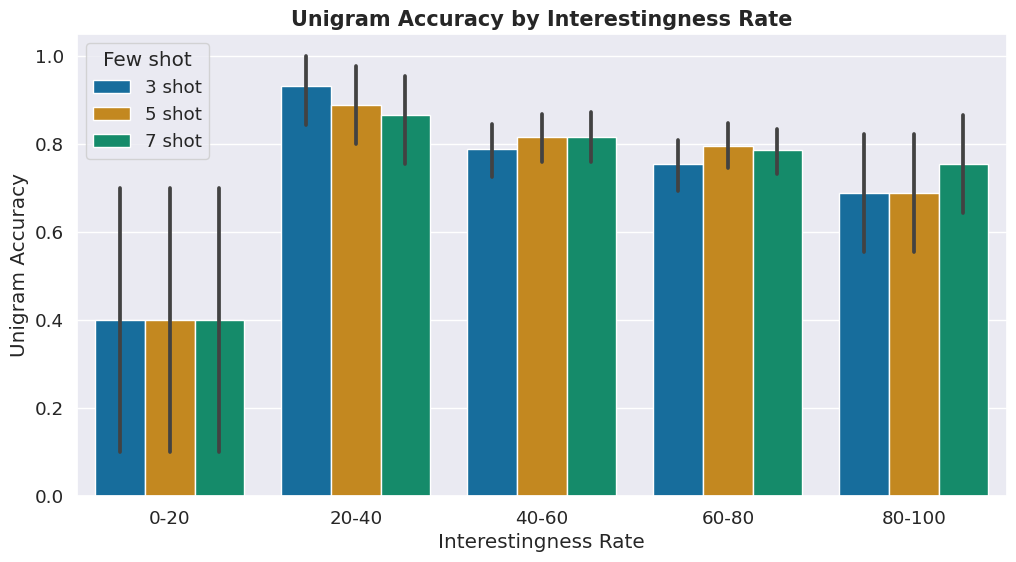

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have a single 'value' column for each output
melted_df = data_by_interest_rate.melt(id_vars='interest_rate_groups', value_vars=['output_binary_3', 'output_binary_5', 'output_binary_7'], var_name='Output', value_name='Value')
melted_df['Output'] = melted_df['Output'].replace({"output_binary_3":"3 shot","output_binary_5":"5 shot","output_binary_7":"7 shot"})
melted_df.rename({"Output":"Few shot", "Value":"Unigram Accuracy", "interest_rate_groups":"Interestingness Rate"}, axis=1, inplace=True)

# Plot the grouped bar plot
plt.figure(figsize=(12,6))
sns.set(font_scale=1.2)
color_palette = sns.color_palette("colorblind")
sns.barplot(data=melted_df, x='Interestingness Rate', y='Unigram Accuracy', hue='Few shot', palette=color_palette)
plt.title('Unigram Accuracy by Interestingness Rate', fontweight='bold', fontsize=15)
plt.show()